### Setting Up Kaggle API and Downloading Dataset

In [1]:
!pip install kaggle
from google.colab import files
files.upload()  # Upload your Kaggle API key here

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d slavkoprytula/aquarium-data-cots
!unzip aquarium-data-cots.zip

Saving kaggle (1).json to kaggle (1).json
mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/slavkoprytula/aquarium-data-cots
License(s): CC0-1.0
 96% 64.0M/66.6M [00:04<00:00, 18.3MB/s]
100% 66.6M/66.6M [00:04<00:00, 15.6MB/s]
Archive:  aquarium-data-cots.zip
  inflating: aquarium_pretrain/README.dataset.txt  
  inflating: aquarium_pretrain/README.roboflow.txt  
  inflating: aquarium_pretrain/data.yaml  
  inflating: aquarium_pretrain/test/images/IMG_2289_jpeg_jpg.rf.fe2a7a149e7b11f2313f5a7b30386e85.jpg  
  inflating: aquarium_pretrain/test/images/IMG_2301_jpeg_jpg.rf.2c19ae5efbd1f8611b5578125f001695.jpg  
  inflating: aquarium_pretrain/test/images/IMG_2319_jpeg_jpg.rf.6e20bf97d17b74a8948aa48776c40454.jpg  
  inflating: aquarium_pretrain/test/images/IMG_2347_jpeg_jpg.rf.7c71ac4b9301eb358cd4a832844dedcb.jpg  
  inflating: aquarium_pretrain/test/images/IMG_2354_

# Installing PyTorch and Dependencies
### This command installs PyTorch and its related libraries (torchvision for computer vision tasks and torchaudio for audio processing) from the official PyTorch repository, specifically with support for CUDA 11.8 (indicated by cu118). This ensures that the libraries are compatible with GPU acceleration for faster computation, especially when running on Google Colab with GPU support.

In [2]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


# Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from collections import Counter
import seaborn as sns
import tqdm
import glob
import os
import json
from PIL import Image
import xml.etree.ElementTree as ET
import pprint
pp = pprint.PrettyPrinter(indent=4)
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms
import torchvision.ops as ops
from torch.utils.data import distributed, RandomSampler, SequentialSampler
import random
import cv2
from collections import Counter

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### Seting the Device for Model Training

In [4]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Code to Define Paths for Data Directories

In [5]:
TRAIN_PATH = "/content/aquarium_pretrain/train"
VAL_PATH = "/content/aquarium_pretrain/valid"
TEST_PATH = "/content/aquarium_pretrain/test"

# Corrected paths by removing the redundant 'TRAIN_PATH' from the labels and images paths.
TRAIN_LABELS = os.path.join(TRAIN_PATH, "labels") # Use os.path.join for platform-independent path construction
VAL_LABELS = os.path.join(VAL_PATH, "labels")
TEST_LABELS = os.path.join(TEST_PATH, "labels")

TRAIN_IMAGES = os.path.join(TRAIN_PATH, "images")
VAL_IMAGES = os.path.join(VAL_PATH, "images")
TEST_IMAGES = os.path.join(TEST_PATH, "images")

### Code to Define Classes and Mappings

In [6]:
classes = ["fish", "jellyfish", "penguin", "puffin", "shark", "starfish", "stingray"]
Idx2Label = {idx: label for idx, label in enumerate(classes)}
Label2Index = {label: idx for idx, label in Idx2Label.items()}
print("Index to Label Mapping:", Idx2Label)
print("Label to Index Mapping:", Label2Index)

Index to Label Mapping: {0: 'fish', 1: 'jellyfish', 2: 'penguin', 3: 'puffin', 4: 'shark', 5: 'starfish', 6: 'stingray'}
Label to Index Mapping: {'fish': 0, 'jellyfish': 1, 'penguin': 2, 'puffin': 3, 'shark': 4, 'starfish': 5, 'stingray': 6}


### Code to Describe the Dataset

In [7]:
import os

def describe_dataset(image_path, label_path):
    images = os.listdir(image_path)
    labels = os.listdir(label_path)
    print(f"Number of images: {len(images)}")
    print(f"Number of labels: {len(labels)}")

describe_dataset(TRAIN_IMAGES, TRAIN_LABELS)

Number of images: 448
Number of labels: 448


### Code to Visualize Images with Annotation Bounding Boxes

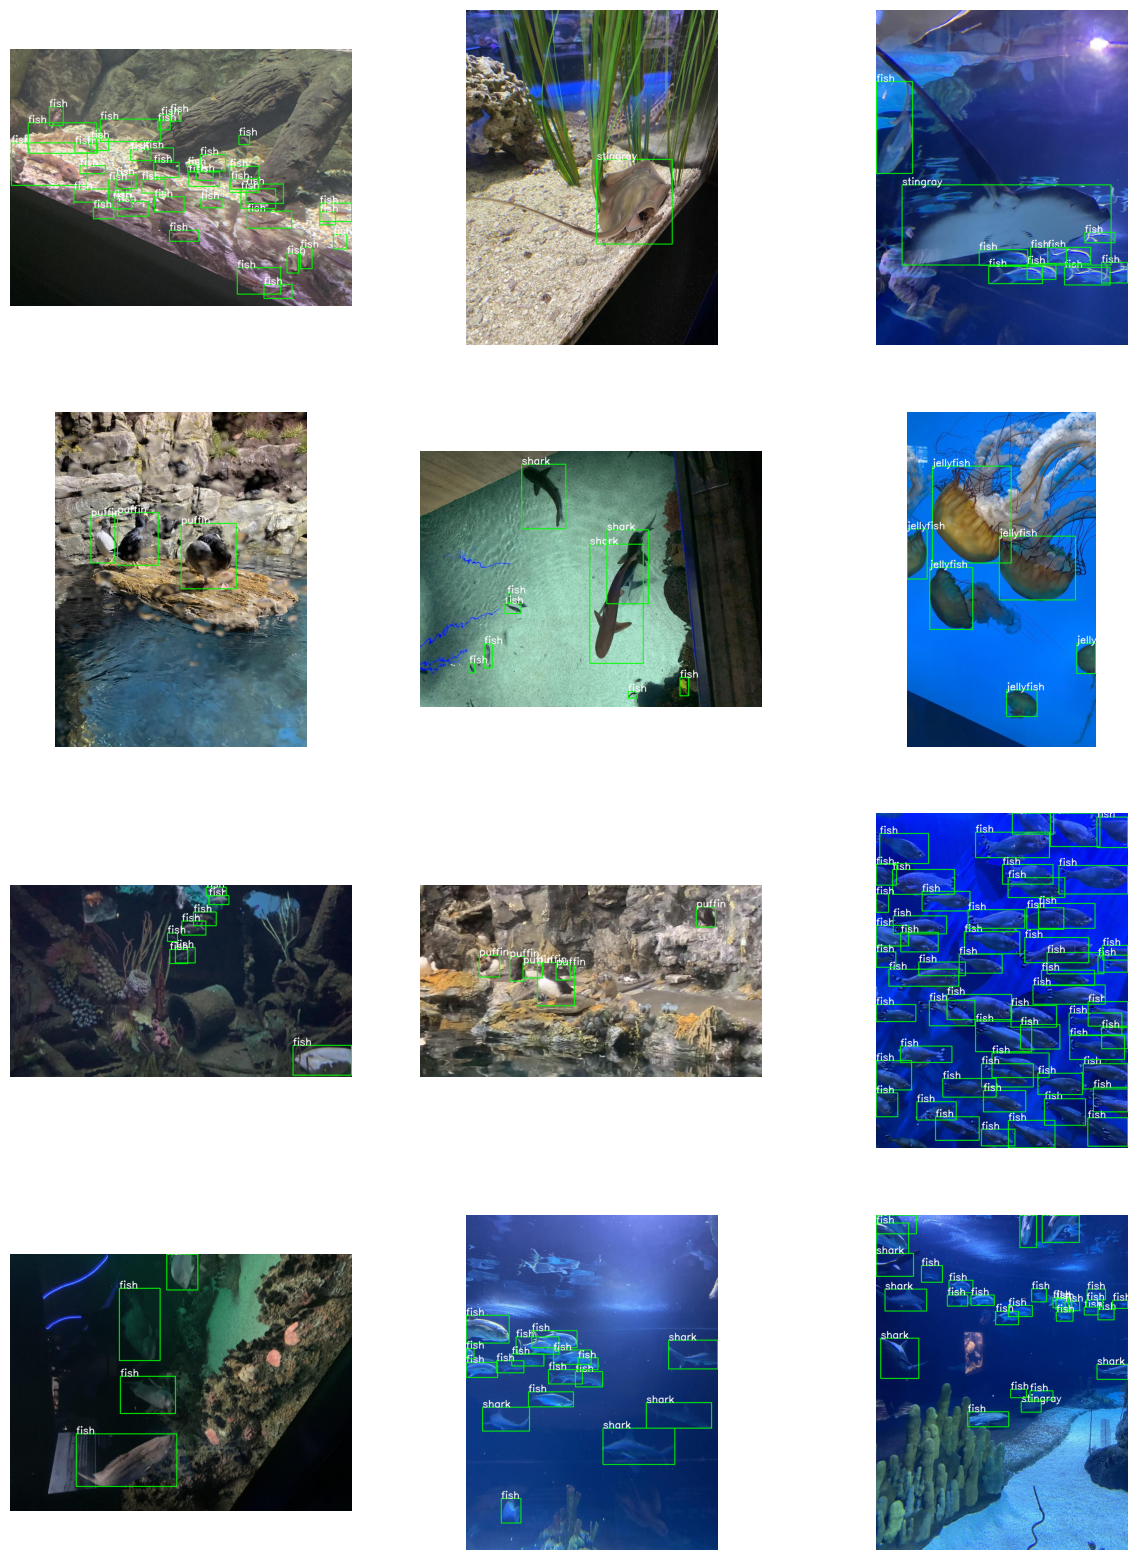

In [8]:
def visualize_image_with_annotation_bboxes(image_dir, label_dir):
    # Get list of all the image files in the directory
    image_files = sorted(os.listdir(image_dir))

    # Choose 10 random image files from the list
    sample_image_files = random.sample(image_files, 12)

    # Set up the plot
    fig, axs = plt.subplots(4, 3, figsize=(15, 20))

    # Loop over the random images and plot the bounding boxes
    for i, image_file in enumerate(sample_image_files):
        row = i // 3
        col = i % 3

        # Load the image
        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load the labels for this image
        label_path = os.path.join(label_dir, image_file[:-4] + '.txt')
        f = open(label_path, 'r')

        # Loop over the labels and plot the bounding boxes
        for label in f:
            class_id, x_center, y_center, width, height = map(float, label.split())
            h, w, _ = image.shape
            x_min = int((x_center - width/2) * w)
            y_min = int((y_center - height/2) * h)
            x_max = int((x_center + width/2) * w)
            y_max = int((y_center + height/2) * h)
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(image, Idx2Label[int(class_id)], (x_min, y_min), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)

        axs[row, col].imshow(image)
        axs[row, col].axis('off')

    plt.show()

# Visualize 6 sample images with bounding boxes
visualize_image_with_annotation_bboxes(TRAIN_IMAGES, TRAIN_LABELS)

### Reading an Image and Geting Its Dimensions

In [9]:
# Read a image by path
image_path = os.path.join(TRAIN_IMAGES, os.listdir(TRAIN_IMAGES)[100])
image = cv2.imread(image_path)

# Get the size of the image
height, width, channels = image.shape
print('The image has dimensions {}x{} and {} channels'.format(height, width, channels))

The image has dimensions 1024x768 and 3 channels


### Import the YOLO class from the `ultralytics` package

In [11]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Visualizing YOLOv8 Training Metrics and Loss
### This code visualizes various training metrics, loss functions, and performance metrics (such as precision, recall, and mean Average Precision or mAP) during YOLOv8 model training. These visualizations help in analyzing the model's performance and progress throughout the training process.

In [37]:
from tqdm import tqdm  # Import tqdm for progress bar during training

# Fine-tune the model on your dataset for 10 epochs
model = YOLO('yolov8n.pt')  # Load the pretrained model

results = model.train(
    data='/content/aquarium_pretrain/data.yaml',
    epochs=10,
    imgsz=(height, width),  # Set image size
    batch=16,
    workers=4,
    name='yolov8n_finetuned',  # Set name for the training run
    verbose=True  # Show more detailed progress
)


Ultralytics 8.3.43 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/aquarium_pretrain/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=(1024, 768), save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=yolov8n_finetuned, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tr

train: Scanning /content/aquarium_pretrain/train/labels.cache... 448 images, 1 backgrounds, 0 corrupt: 100%|██████████| 448/448 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/aquarium_pretrain/valid/labels.cache... 127 images, 0 backgrounds, 0 corrupt: 100%|██████████| 127/127 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8n_finetuned/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8n_finetuned
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      5.57G      1.518      4.017      1.404        132       1024: 100%|██████████| 28/28 [00:25<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]

                   all        127        909     0.0178       0.57     0.0751     0.0403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10       5.9G      1.516      3.046      1.424        112       1024: 100%|██████████| 28/28 [00:19<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]

                   all        127        909      0.377     0.0715      0.148     0.0844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      5.67G      1.501      2.743      1.376        112       1024: 100%|██████████| 28/28 [00:19<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]

                   all        127        909      0.357      0.233      0.282       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      5.91G      1.513      2.489      1.378         89       1024: 100%|██████████| 28/28 [00:20<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]

                   all        127        909      0.491      0.419      0.413      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      5.55G      1.449      2.328      1.335        101       1024: 100%|██████████| 28/28 [00:20<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]

                   all        127        909      0.498      0.457      0.428      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      5.68G      1.452      2.202      1.342        138       1024: 100%|██████████| 28/28 [00:19<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]

                   all        127        909      0.596      0.458      0.504      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      5.54G      1.407       2.06      1.316        160       1024: 100%|██████████| 28/28 [00:20<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]

                   all        127        909      0.648      0.543      0.595      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      5.48G       1.37       1.93      1.286         84       1024: 100%|██████████| 28/28 [00:20<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

                   all        127        909      0.703      0.551       0.63      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      5.99G      1.328      1.852      1.266        147       1024: 100%|██████████| 28/28 [00:20<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        127        909      0.731      0.578      0.649      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      5.96G      1.326      1.775      1.239        134       1024: 100%|██████████| 28/28 [00:19<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]

                   all        127        909      0.808      0.569      0.673      0.384



10 epochs completed in 0.072 hours.
Optimizer stripped from runs/detect/yolov8n_finetuned/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/yolov8n_finetuned/weights/best.pt, 6.3MB

Validating runs/detect/yolov8n_finetuned/weights/best.pt...
Ultralytics 8.3.43 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,007,013 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.06s/it]


                   all        127        909      0.809      0.569      0.672      0.383
                  fish         63        459      0.831       0.57      0.737      0.421
             jellyfish          9        155      0.853      0.789      0.868      0.486
               penguin         17        104      0.728      0.565      0.666      0.304
                puffin         15         74      0.788      0.297      0.415      0.192
                 shark         28         57       0.81      0.579      0.625      0.327
              starfish         17         27        0.9      0.519      0.662      0.473
              stingray         23         33      0.752      0.667      0.734       0.48
Speed: 0.4ms preprocess, 5.4ms inference, 0.0ms loss, 23.5ms postprocess per image
Results saved to runs/detect/yolov8n_finetuned


### Load a Pre-trained YOLOv8 Nano Model and Train It

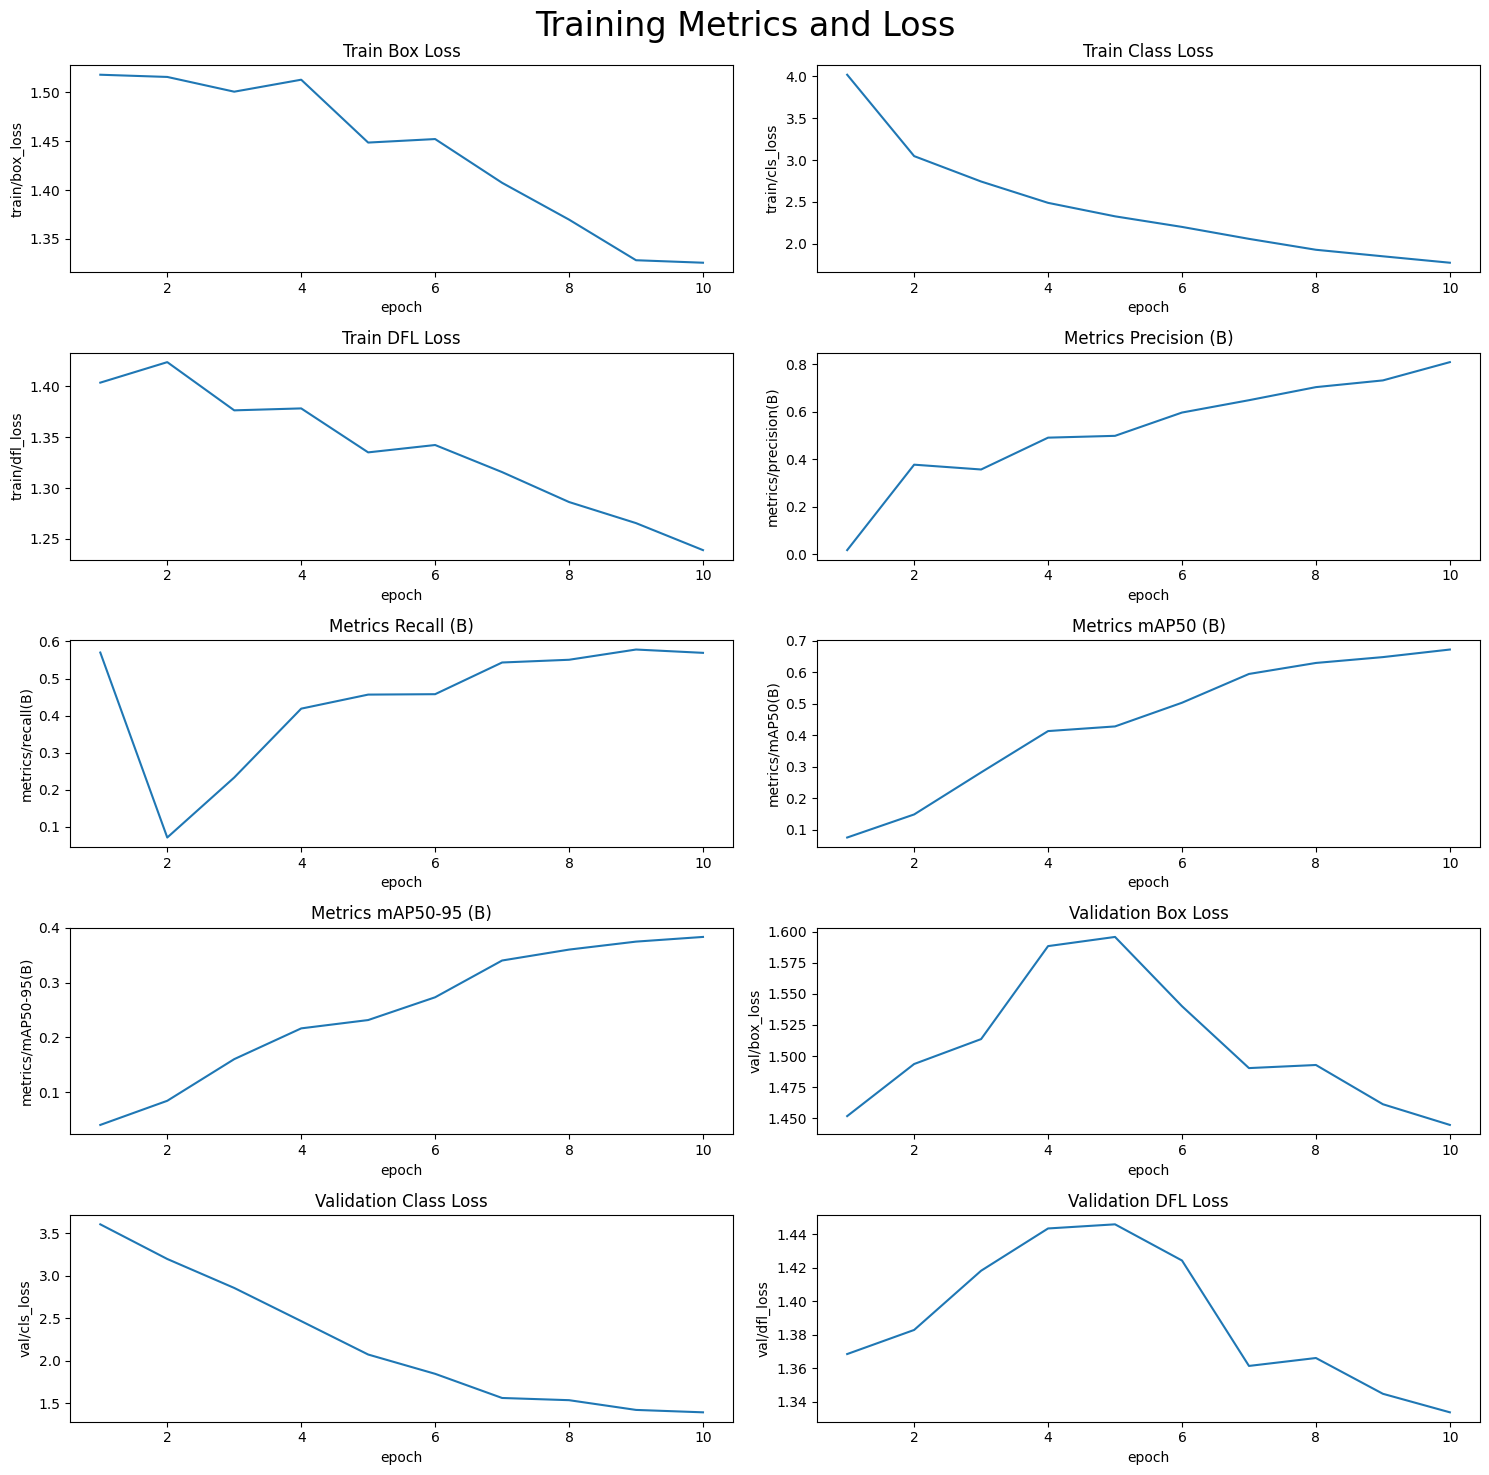

In [39]:
%matplotlib inline
# read in the results.csv file as a pandas dataframe
df = pd.read_csv('/content/runs/detect/yolov8n_finetuned/results.csv')
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()

# Evaluating the Best Performing YOLOv8 Model
### The function returns metrics such as precision, recall, mAP (mean Average Precision), etc., which help evaluate how well the model performs on the validation or test dataset.

In [40]:
from ultralytics import YOLO
# Loading the best performing model
model = YOLO('/content/runs/detect/yolov8n_finetuned/weights/best.pt')

# Evaluating the model on test dataset
# The original code uses split='test' which might not be defined in your data.yaml.
# Assuming your data.yaml has 'val' for validation data:
metrics = model.val(data="/content/aquarium_pretrain/data.yaml", conf=0.25, split='val')
# If you have a 'test' split in your data.yaml, make sure the path is correct.

Ultralytics 8.3.43 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,007,013 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/aquarium_pretrain/valid/labels.cache... 127 images, 0 backgrounds, 0 corrupt: 100%|██████████| 127/127 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


                   all        127        909      0.807      0.569        0.7      0.439
                  fish         63        459      0.832       0.57      0.736      0.458
             jellyfish          9        155      0.851      0.787      0.867      0.533
               penguin         17        104      0.719      0.566      0.656      0.335
                puffin         15         74      0.788      0.297      0.505      0.276
                 shark         28         57      0.809      0.579      0.678      0.387
              starfish         17         27      0.899      0.519      0.705      0.553
              stingray         23         33      0.751      0.667      0.749      0.527
Speed: 0.8ms preprocess, 8.9ms inference, 0.0ms loss, 6.7ms postprocess per image
Results saved to runs/detect/val3


# Printing Model Evaluation Metrics
### This prints the Mean Average Precision over the range [0.5, 0.95], which is a standard evaluation metric for object detection tasks.

In [41]:
print(f"Mean Average Precision @.5:.95 : {metrics.box.map}")
print(f"Mean Average Precision @ .50   : {metrics.box.map50}")
print(f"Mean Average Precision @ .70   : {metrics.box.map75}")

Mean Average Precision @.5:.95 : 0.4385325547725924
Mean Average Precision @ .50   : 0.6995495511504751
Mean Average Precision @ .70   : 0.43526759740481974


# Evaluating YOLOv8 Model Performance Using mAP
### This code evaluates the YOLOv8 model's performance on the validation dataset, specifically focusing on the mAP at IoU=0.5.

In [42]:
metrics = model.val(data="/content/aquarium_pretrain/data.yaml", conf=0.5)  # Set threshold to 0.5
print(f"Mean Average Precision @0.5 : {metrics.box.map50}")


Ultralytics 8.3.43 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/aquarium_pretrain/valid/labels.cache... 127 images, 0 backgrounds, 0 corrupt: 100%|██████████| 127/127 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


                   all        127        909      0.838      0.554      0.708       0.46
                  fish         63        459      0.861       0.54      0.714      0.461
             jellyfish          9        155      0.869      0.768      0.846      0.531
               penguin         17        104      0.746       0.51      0.626      0.337
                puffin         15         74      0.815      0.297      0.529      0.298
                 shark         28         57      0.825      0.579      0.723      0.423
              starfish         17         27      0.933      0.519      0.743      0.625
              stingray         23         33      0.815      0.667      0.772      0.546
Speed: 0.9ms preprocess, 9.0ms inference, 0.0ms loss, 13.3ms postprocess per image
Results saved to runs/detect/val4
Mean Average Precision @0.5 : 0.7075391382641445


# Function to Perform Detections with Trained YOLO Model
### This function is designed to perform inference on an image using the YOLO model, displaying the results with the predicted bounding boxes for object detection tasks.

In [43]:
# Function to perform detections with trained model
def predict_detection(image_path):
    # Read the image
    image = cv2.imread(image_path)

    # Pass the image through the detection model and get the result
    detect_result = model(image)

    # Plot the detections
    detect_image = detect_result[0].plot()

    # Convert the image to RGB format
    detect_image = cv2.cvtColor(detect_image, cv2.COLOR_BGR2RGB)

    return detect_image

# YOLO Object Detection on Sample Test Images
### This code allows you to visualize object detection results from the trained YOLO model on a subset of test images. Each image has bounding boxes drawn around the detected objects, and the images are displayed in a grid.


0: 1024x576 6 fishs, 11.9ms
Speed: 4.1ms preprocess, 11.9ms inference, 2.2ms postprocess per image at shape (1, 3, 1024, 576)

0: 1024x768 1 puffin, 12.2ms
Speed: 4.5ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 768)

0: 768x1024 25 fishs, 1 shark, 11.8ms
Speed: 4.8ms preprocess, 11.8ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

0: 1024x576 7 fishs, 10.0ms
Speed: 2.5ms preprocess, 10.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 576)

0: 1024x768 1 fish, 3 starfishs, 11.8ms
Speed: 3.9ms preprocess, 11.8ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 768)

0: 1024x768 10 penguins, 11.3ms
Speed: 3.6ms preprocess, 11.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 768)

0: 1024x768 1 fish, 4 jellyfishs, 20.2ms
Speed: 3.7ms preprocess, 20.2ms inference, 2.1ms postprocess per image at shape (1, 3, 1024, 768)

0: 1024x768 2 fishs, 2 stingrays, 11.3ms
Speed: 3.8ms preprocess, 11.3

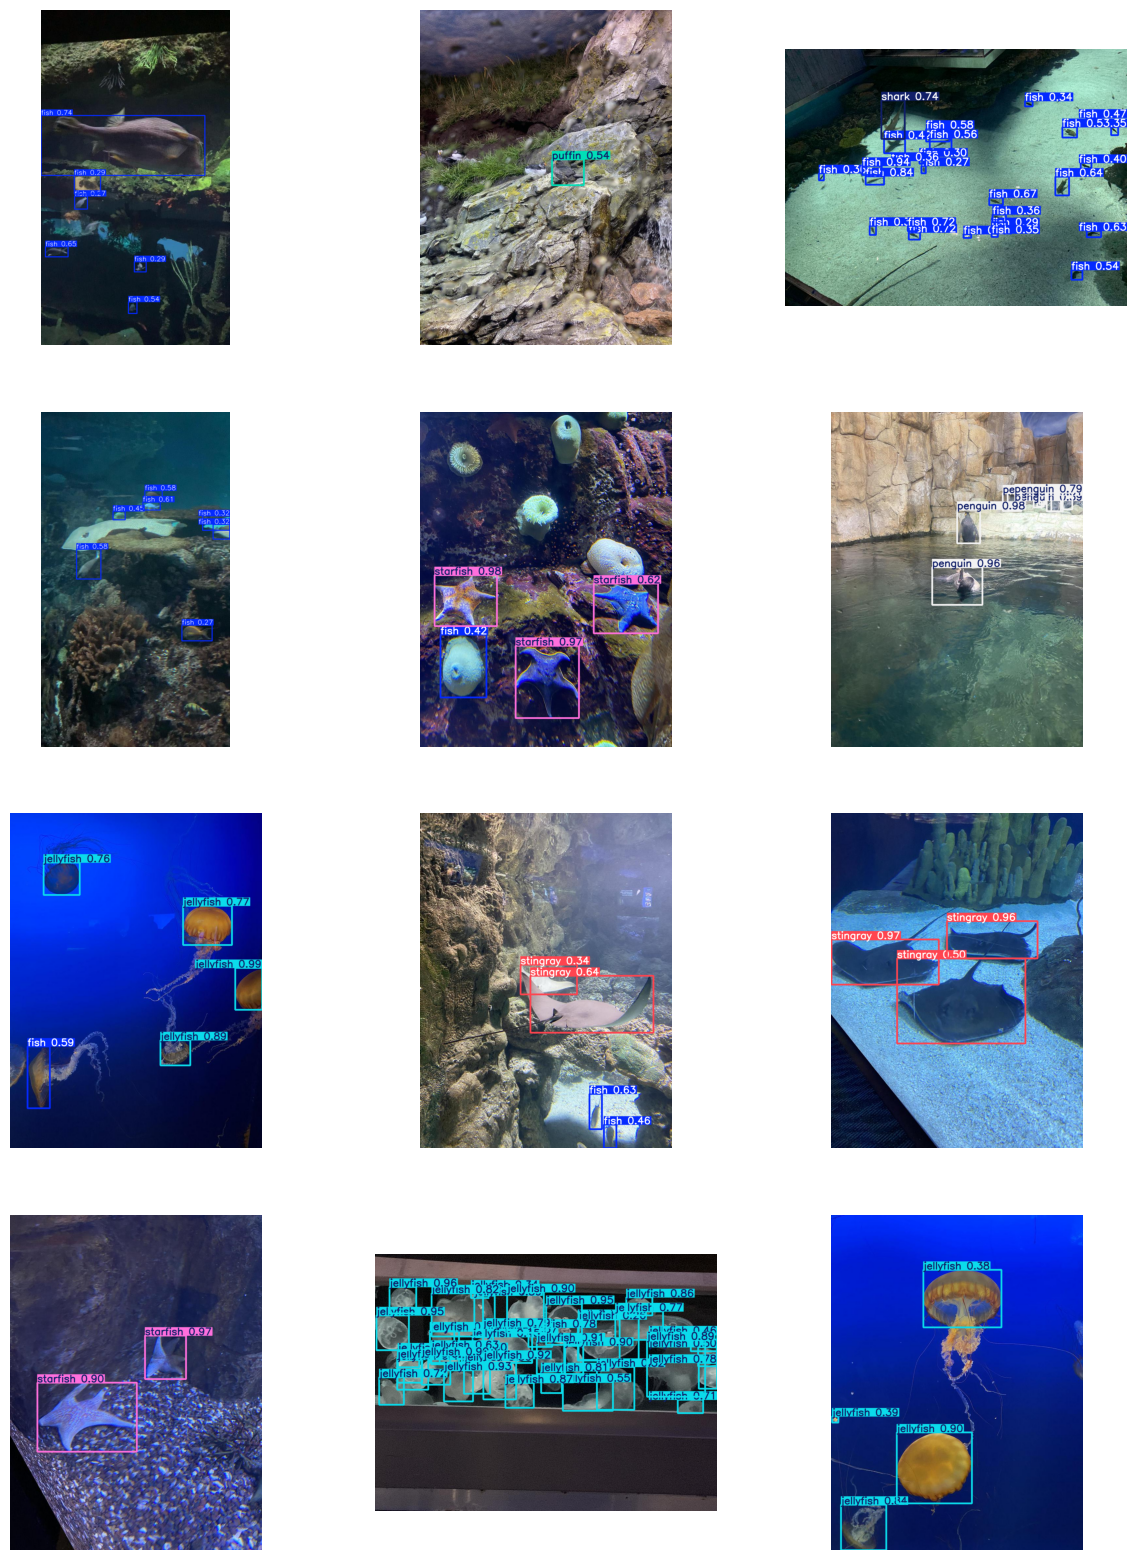

In [44]:
import os # import the os module
import random
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO # import the YOLO class

# Loading the best performing model
model = YOLO('/content/runs/detect/yolov8n_finetuned/weights/best.pt') # define model here

# Function to perform detections with trained model
def predict_detection(image_path):
    # Read the image
    image = cv2.imread(image_path)

    # Pass the image through the detection model and get the result
    detect_result = model(image) # Now 'model' is accessible

    # Plot the detections
    detect_image = detect_result[0].plot()

    # Convert the image to RGB format
    detect_image = cv2.cvtColor(detect_image, cv2.COLOR_BGR2RGB)

    return detect_image
# Define the path to the directory containing test images
# Replace 'path/to/your/test/images' with the actual path
TEST_IMAGES = '/content/aquarium_pretrain/test/images'

# Get list of all the image files in the test directory
image_files = sorted(os.listdir(TEST_IMAGES))

# Choose 12 random image files from the list
sample_image_files = random.sample(image_files, 12)

# Set up the plot
fig, axs = plt.subplots(4, 3, figsize=(15, 20))

# Loop over the random images and plot the detections of the trained model
for i, image_file in enumerate(sample_image_files):
    row = i // 3
    col = i % 3

    # Load the current image and run object detection
    image_path = os.path.join(TEST_IMAGES, image_file)
    detect_image = predict_detection(image_path)

    axs[row, col].imshow(detect_image)
    axs[row, col].axis('off')

plt.show()

# Object Detection and Evaluation: Comparing Predicted and True Bounding Boxes Using YOLOv8
### This code performs object detection on test images, compares predicted bounding boxes with true bounding boxes, and visualizes the results. It uses a trained YOLO model (yolov8n_custom) to make predictions, and compares those predictions with ground truth annotations.


0: 1024x576 6 fishs, 1 jellyfish, 11.5ms
Speed: 2.5ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 576)

0: 1024x768 2 stingrays, 12.2ms
Speed: 2.9ms preprocess, 12.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 768)

0: 1024x768 1 fish, 1 shark, 12.0ms
Speed: 2.9ms preprocess, 12.0ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 768)

0: 1024x768 2 puffins, 11.8ms
Speed: 3.0ms preprocess, 11.8ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 768)

0: 1024x576 1 fish, 10.6ms
Speed: 2.5ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 576)

0: 1024x768 1 fish, 1 jellyfish, 11.8ms
Speed: 3.0ms preprocess, 11.8ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 768)

0: 1024x768 1 stingray, 11.9ms
Speed: 2.8ms preprocess, 11.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 768)

0: 1024x768 1 starfish, 11.8ms
Speed: 2.9ms preprocess, 11.8ms infere

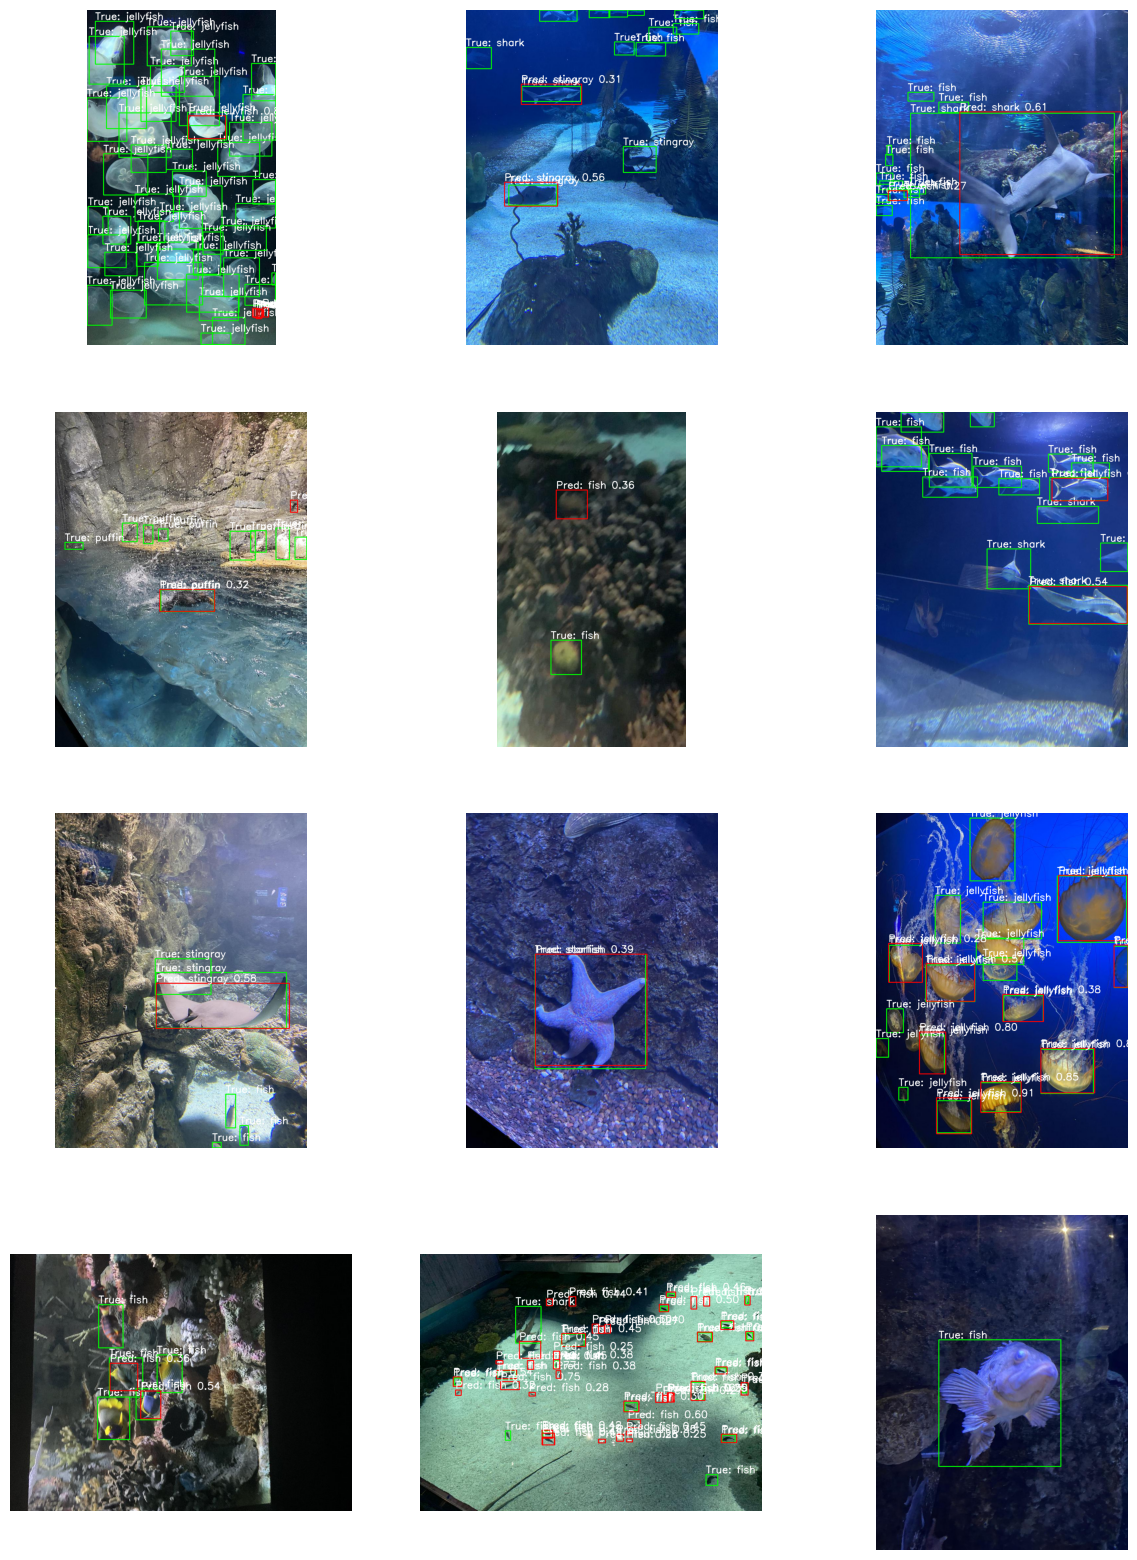

In [45]:
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
import random
import os

# Define mappings
Idx2Label = {0: 'fish', 1: 'jellyfish', 2: 'penguin', 3: 'puffin', 4: 'shark', 5: 'starfish', 6: 'stingray'}
Label2Idx = {'fish': 0, 'jellyfish': 1, 'penguin': 2, 'puffin': 3, 'shark': 4, 'starfish': 5, 'stingray': 6}

# Function to load true bounding boxes
def load_true_bboxes(label_path, img_width, img_height):
    true_bboxes = []
    with open(label_path, 'r') as f:
        for line in f:
            class_id, x_center, y_center, width, height = map(float, line.split())
            x_min = int((x_center - width / 2) * img_width)
            y_min = int((y_center - height / 2) * img_height)
            x_max = int((x_center + width / 2) * img_width)
            y_max = int((y_center + height / 2) * img_height)
            true_bboxes.append((x_min, y_min, x_max, y_max, int(class_id)))
    return true_bboxes

# Updated function to include true and predicted bounding boxes
def predict_and_plot_with_true_boxes(image_path, label_path):
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    # Load true bounding boxes
    true_bboxes = load_true_bboxes(label_path, w, h)

    # Draw true bounding boxes in green (with larger font size for clarity)
    for bbox in true_bboxes:
        x_min, y_min, x_max, y_max, class_id = bbox
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)  # Green box for true labels
        cv2.putText(image, f"True: {Idx2Label[class_id]}", (x_min, y_min - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), 2)  # White text, larger font

    # Perform predictions
    model = YOLO('/content/runs/detect/yolov8n_finetuned/weights/best.pt')  # Load the model (you might need to adjust this path)
    detect_result = model(image)
    for *xyxy, conf, cls in detect_result[0].boxes.data:  # Unpack xyxy, conf, cls
        x_min, y_min, x_max, y_max = map(int, xyxy)
        confidence = conf.item()  # Extract confidence score
        class_id = int(cls.item())  # Extract class ID
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)  # Blue box for predicted labels
        cv2.putText(image, f"Pred: {Idx2Label[class_id]} {confidence:.2f}", (x_min, y_min - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), 2)  # White text, larger font

    return image

# Path to the test images and labels
TEST_IMAGES = '/content/aquarium_pretrain/test/images'
TEST_LABELS = '/content/aquarium_pretrain/test/labels'

# Get a list of test images
image_files = sorted(os.listdir(TEST_IMAGES))
sample_image_files = random.sample(image_files, 12)

# Create subplots to display the images
fig, axs = plt.subplots(4, 3, figsize=(15, 20))
for i, image_file in enumerate(sample_image_files):
    row = i // 3
    col = i % 3

    # Load image and label paths
    image_path = os.path.join(TEST_IMAGES, image_file)
    label_path = os.path.join(TEST_LABELS, image_file.replace('.jpg', '.txt'))

    # Get the annotated image
    detect_image = predict_and_plot_with_true_boxes(image_path, label_path)

    # Plot the results
    axs[row, col].imshow(detect_image)
    axs[row, col].axis('off')

plt.show()
